In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Standard libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Prepare the MNIST dataset

In [5]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(int)

# Split training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Vectorize the images by flattening them into 1D arrays
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Perform a stratified split to create a validation set from the training data
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

### Define the model building function for Keras Tuner

In [6]:
def build_model(hp):
    model = keras.models.Sequential()

    # Input layer for 28*28=784-dimensional vector input
    model.add(keras.layers.InputLayer(input_shape=(784,)))

    # Tune the number of hidden layers abetween 2 and 6 hidden layers
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64)
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'silu'])))
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.3, step=0.05)))


    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [9]:
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


### Fine tuning the model

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train in each trial
    directory='directory_0',  # Directory to save the search results
    project_name='mnist_kt',
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)


tuner.search(
    X_train_part, y_train_part,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping, lr_scheduler],
)

Trial 25 Complete [00h 02m 41s]
val_accuracy: 0.9853333234786987

Best val_accuracy So Far: 0.9854999780654907
Total elapsed time: 01h 21m 51s


### Training the fine-tuned model

In [11]:
# Retrieve the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Print the model summary
model.summary()

# Define early stopping callback to monitor training accuracy
early_stopping = EarlyStopping(
    monitor="accuracy",
    patience=10,
    restore_best_weights=True
)

# Define learning rate reduction callback to prevent divergence in later epochs
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",    # Monitor validation loss to reduce learning rate
    factor=0.5,            # Reduce the learning rate by half
    patience=5,            # Wait 5 epochs before reducing
    min_lr=1e-6,           # Set a minimum learning rate
    verbose=1              # Print messages during training
)

# Train the model on the full training data and track training time
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=37,
    batch_size=32,
    validation_split=0.1,
    callbacks=[reduce_lr]
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:,.3f} seconds")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 320)                 │         164,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 320)                 │           1,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 320)                 │         102,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 320)                 │           1,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 192)                 │          61,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 192)                 │              

 Total params: 1,002,442 (3.82 MB)

 Trainable params: 998,730 (3.81 MB)

 Non-trainable params: 3,712 (14.50 KB)

Epoch 1/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8541 - loss: 0.4688 - val_accuracy: 0.9673 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 2/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9442 - loss: 0.1801 - val_accuracy: 0.9753 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 3/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9575 - loss: 0.1348 - val_accuracy: 0.9755 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 4/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9690 - loss: 0.1051 - val_accuracy: 0.9790 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 5/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9720 - loss: 0.0880 - val_accuracy: 0.9813 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 6/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9759 - loss: 0.0743 - val_accuracy: 0.9802 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 7/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.979

In [12]:
hist = pd.DataFrame(history.history)
hist

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.903019,0.315827,0.967333,0.111493,0.001000
1,0.946944,0.171191,0.975333,0.082202,0.001000
2,0.958611,0.132619,0.975500,0.080601,0.001000
3,0.968222,0.104412,0.979000,0.072963,0.001000
4,0.971889,0.087939,0.981333,0.068136,0.001000
5,0.975759,0.075294,0.980167,0.066271,0.001000
6,0.979500,0.063671,0.982500,0.068529,0.001000
7,0.983204,0.051845,0.982500,0.076147,0.001000
8,0.984685,0.047592,0.981000,0.074944,0.001000
9,0.985944,0.043648,0.981333,0.080350,0.001000


### Best parameters

In [13]:
# Printing best parameters
best_hps_dict = best_hps.values
df = pd.DataFrame.from_dict(best_hps_dict, orient='index', columns=['Value']) # Create DataFrame with values as a column
df.index.name = 'Hyperparameter' # Set index name to 'Hyperparameter'
df

,Value
Hyperparameter,
num_layers,5
units_0,512
activation_0,silu
dropout_0,0.2
units_1,512
activation_1,relu
dropout_1,0.1
learning_rate,0.001
units_2,320


### Plot training and validation accuracy over epochs

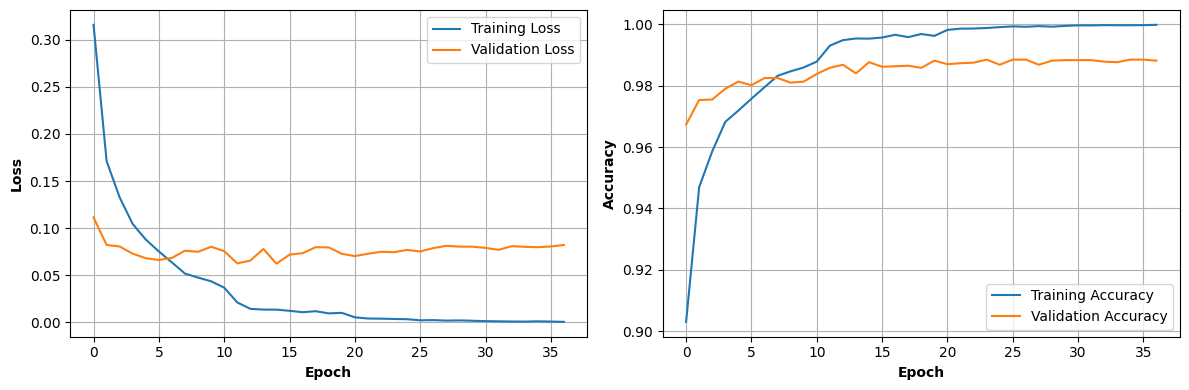

In [14]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch',  fontweight='bold')
plt.ylabel('Loss',  fontweight='bold')
plt.title('') # Training and Validation Loss
plt.legend()
plt.grid(True) # Add grid to the first subplot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch',  fontweight='bold')
plt.ylabel('Accuracy',  fontweight='bold')
plt.title('') #  Training and Validation Accuracy
plt.legend()
plt.grid(True) # Add grid to the second subplot

plt.tight_layout()
plt.show()

### Plot Learning Rate over Epochs

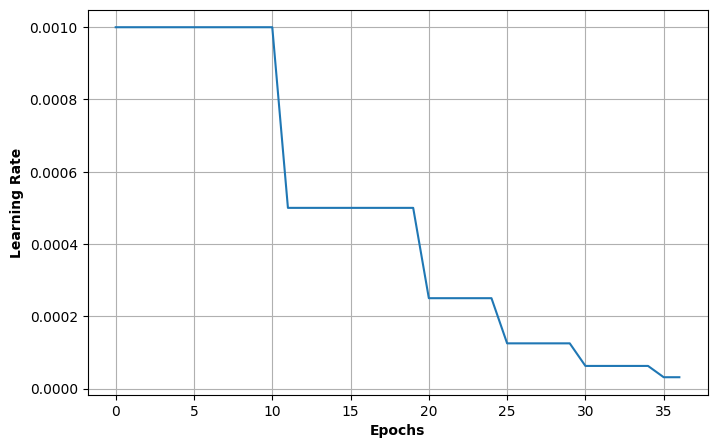

In [15]:
learning_rate = pd.DataFrame(history.history)['learning_rate']

# plot learning rate with grids
plt.figure(figsize=(8, 5))
plt.plot(learning_rate)
plt.title('') #  Learning Rate
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Learning Rate', fontweight='bold')
plt.grid(True)
plt.show()

### Evaluation Metrics

In [19]:
y_pred = model.predict(X_test).argmax(axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Training Time:", training_time)


# Overfitting/Underfitting Detection
train_acc = history.history['accuracy'][-1]  # Get final training accuracy
test_acc = accuracy  # Assuming you have test accuracy

# If training accuracy is much higher than test accuracy, it might indicate overfitting.
# If both training and test accuracy are low, it might indicate underfitting.
if train_acc > test_acc + 0.1:  # threshold for overfitting
    print("Potential Overfitting Detected!")
elif train_acc < test_acc - 0.1:  # threshold for underfitting
    print("Potential Underfitting Detected!")
else:
    print("No indication of overfitting or underfitting.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.9881
Precision: 0.9881042910702607
Recall: 0.9881
F1-Score: 0.9880966886588907
Training Time: 289.3518946170807
No indication of overfitting or underfitting.


### Utility function

In [20]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label',  fontweight='bold')
    plt.xlabel('Predicted label',  fontweight='bold')
    plt.tight_layout()

### Confusion Matrix (Optional)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


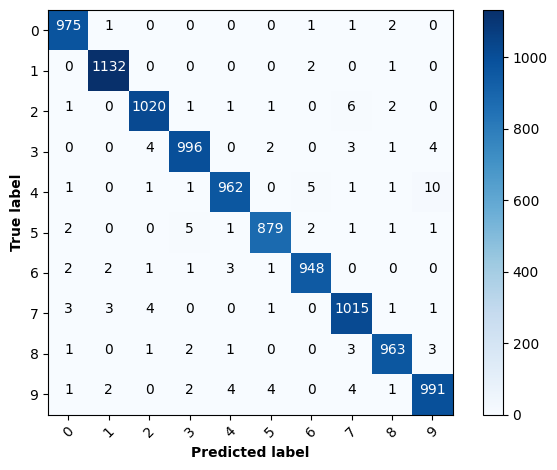

In [21]:
y_pred = model.predict(X_test).argmax(axis=1)

y_test_labels = y_test
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plot_confusion_matrix(conf_matrix, classes=range(10), title="")
plt.show()